In [1]:
import os
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import random
from data_preprocess import extract_stft_features

In [2]:
def load_segmented_files(directory, target_sr=4800):
    wav_files = []
    leak_wav_files = []
    for dir in os.listdir(directory):
        if not os.path.isdir(os.path.join(directory, dir)):
            continue
        for file in os.listdir(os.path.join(directory, dir)):
            if not file.endswith(".wav"):
                continue
            file_path = os.path.join(directory, dir, file)
            y, sr = librosa.load(file_path, sr=None)
            # print(f"檔案 {file_path} 的取樣率為 {sr}")
            if sr != target_sr:
                y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
            filename = f'{dir}_{file}'
            if 'no-leak' in dir:
                wav_files.append((y, sr, filename))
            else:
                leak_wav_files.append((y, sr, filename))
    print(f"共有 {len(wav_files) + len(leak_wav_files)} 個 wav 檔案，其中 {len(leak_wav_files)} 個有泄漏，{len(wav_files)} 個沒有泄漏")
    return wav_files, leak_wav_files

def shuffle_data(wav_files, leak_wav_files, n_files=None):
    wav_files = random.sample(wav_files, n_files if n_files else len(wav_files))
    leak_wav_files = random.sample(leak_wav_files, n_files if n_files else len(leak_wav_files))

    return wav_files, leak_wav_files


In [3]:
# 載入訓練資料
wav_files, leak_wav_files = load_segmented_files('training_data')
wav_files, leak_wav_files = shuffle_data(wav_files, leak_wav_files, n_files=10)

共有 2946 個 wav 檔案，其中 646 個有泄漏，2300 個沒有泄漏


In [4]:
def wav2mfcc(wave, sr, desired_time=2.0, n_mfcc=128, hop_length=512):
    max_len = int(np.ceil((desired_time * sr) / hop_length))
    # 計算下個 2 的冪次倍數
    target_len = int(np.ceil(max_len / 8) * 8)
    
    # 明確地以關鍵字形式傳遞參數 y 和 sr
    mfcc = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=n_mfcc, hop_length=512)
    
    # 填充或截斷至 target_len
    if mfcc.shape[1] < target_len:
        pad_width = target_len - mfcc.shape[1]
        mfcc = np.pad(
            mfcc, ((0, 0), (0, pad_width)), mode='constant'
        )
    else:
        mfcc = mfcc[:, :target_len]
    
    return mfcc

In [5]:
def extract_features(audio, sr, n_mels=128, n_fft=2048, hop_length=512, desired_time=2.0, transform=True):
    """
    提取 Mel 頻譜圖特徵，並根據目標時間長度進行填充或截斷，
    確保時間幀數是 2 的冪次倍數。

    Args:
        audio (np.ndarray): 音訊資料。
        sr (int): 取樣率。
        n_mels (int): Mel 頻帶數。
        n_fft (int): FFT 大小。
        hop_length (int): hop length。
        desired_time (float): 目標時間長度（秒）。

    Returns:
        np.ndarray: 處理後的 Mel 頻譜圖，形狀為 (target_len, n_mels)。
    """
    max_len = int(np.ceil((desired_time * sr) / hop_length))
    # 計算下個 2 的冪次倍數
    target_len = int(np.ceil(max_len / 8) * 8)

    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length, window='hamming',
    )
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    # log_mel_spectrogram = log_mel_spectrogram.T  # 形狀變為 (時間, n_mels)

    # 填充或截斷至 target_len
    if log_mel_spectrogram.shape[0] < target_len:
        pad_width = target_len - log_mel_spectrogram.shape[0]
        log_mel_spectrogram = np.pad(
            log_mel_spectrogram, ((0, pad_width), (0, 0)), mode='constant'
        )
    else:
        log_mel_spectrogram = log_mel_spectrogram[:target_len, :]

    return log_mel_spectrogram

In [6]:
normal_wavs = np.array([y for y, sr, filename in wav_files])
leak_wavs = np.array([y for y, sr, filename in leak_wav_files])

In [20]:
def plot_mfcc(mfcc, sr=48000, hop_length=512):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time', sr=sr, hop_length=hop_length, cmap='jet')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()

def plot_mel_spectrogram(mel_spectrogram, sr, hop_length):
    """
    繪製 Mel 頻譜圖。

    Args:
        mel_spectrogram (np.ndarray): Mel 頻譜圖，形狀為 (時間, n_mels)。
        sr (int): 取樣率。
        hop_length (int): hop length。
    """
    plt.figure(figsize=(10, 4))
    # 繪製 Mel 頻譜圖
    librosa.display.specshow(mel_spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='jet')
    # 設定 y 軸的頻率刻度最大 500 Hz 刻度為 50 Hz
    # plt.ylim(0, 1600)
    # plt.yticks(np.arange(0, 1600, 150))
    
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.show()
    
    
def plot_stft(S_db, sr, hop_length=512):
    """
    繪製音訊的短時傅立葉變換（STFT）。

    Args:
        audio (np.ndarray): 音訊資料。
        sr (int): 取樣率。
        hop_length (int): hop length。
    """


    # 繪製 STFT 頻譜圖
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='log', y_axis='time', cmap='jet')
    plt.colorbar(format='%+2.0f dB')
    plt.title('STFT Magnitude')
    plt.tight_layout()
    plt.show()

(12, 24)


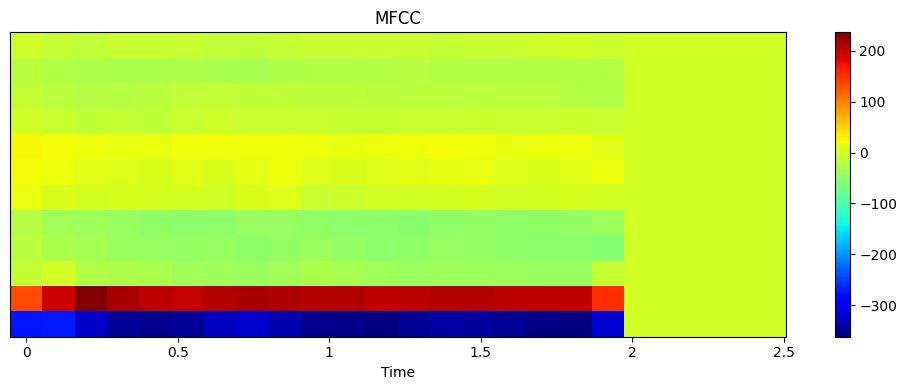

(12, 24)


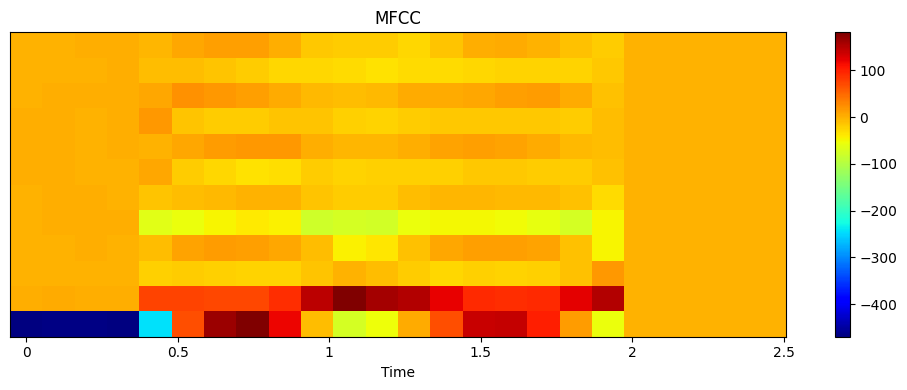

(12, 24)


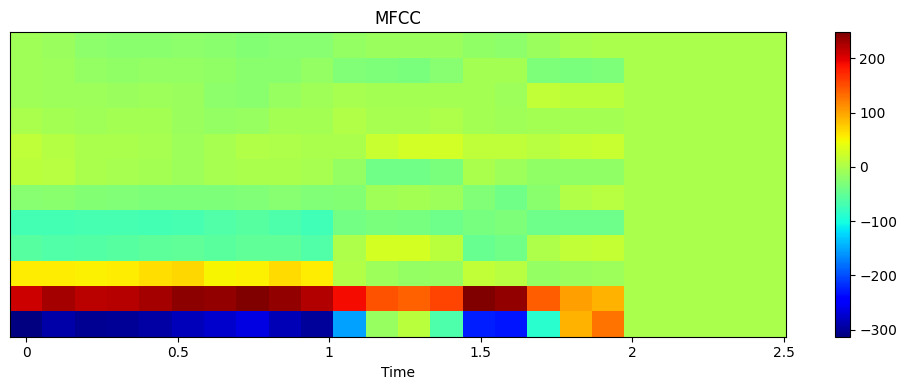

(12, 24)


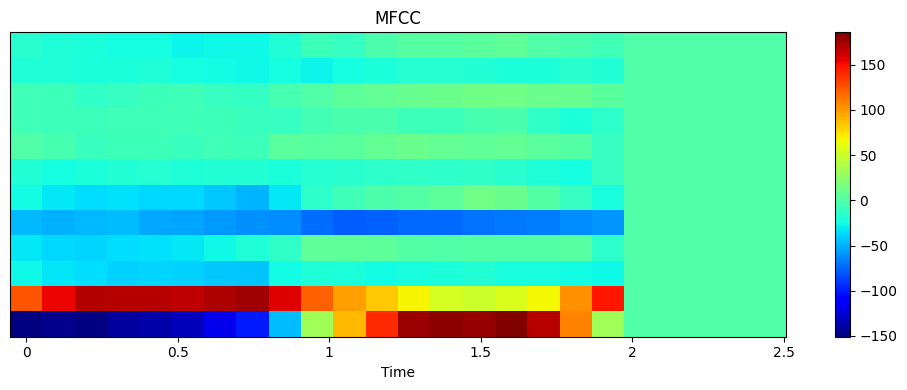

(12, 24)


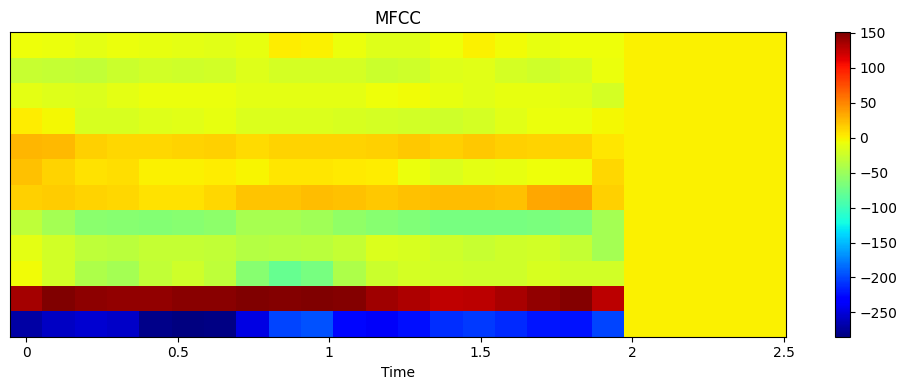

In [8]:
# 繪製 MFCC 圖
hop_length = 512
for i in normal_wavs[:5]:
    mfcc = wav2mfcc(i, sr=4800, desired_time=2.0, hop_length=hop_length, n_mfcc=12)
    print(mfcc.shape)
    plot_mfcc(mfcc, sr=4800, hop_length=hop_length)

(12, 24)


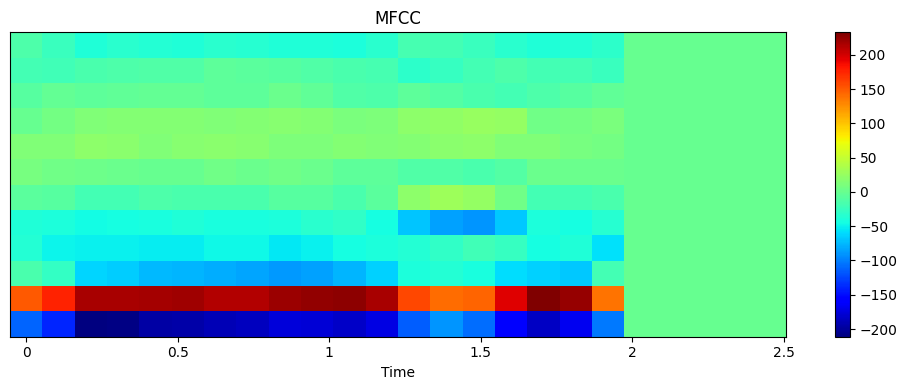

(12, 24)


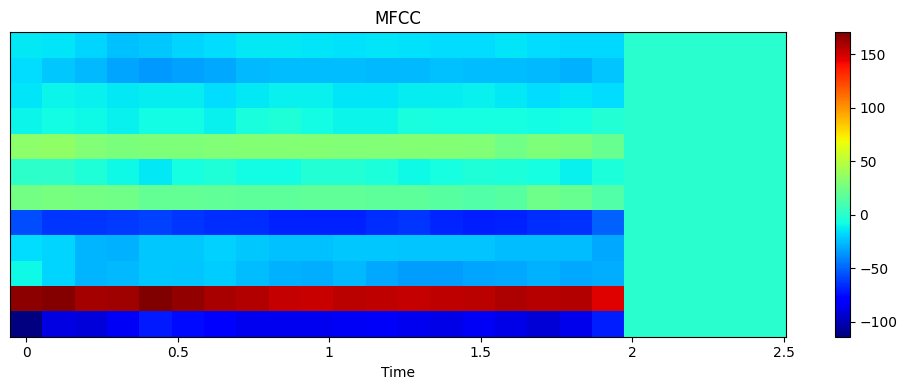

(12, 24)


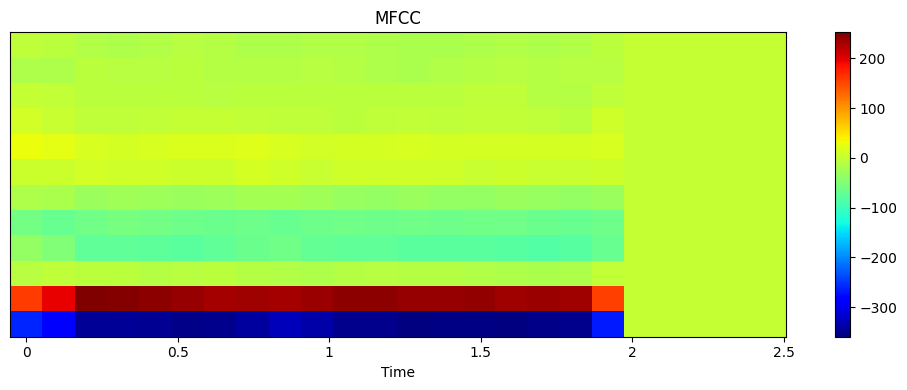

(12, 24)


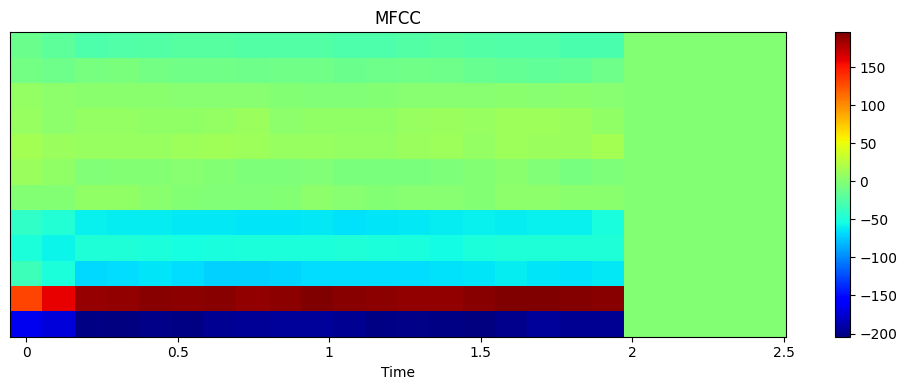

(12, 24)


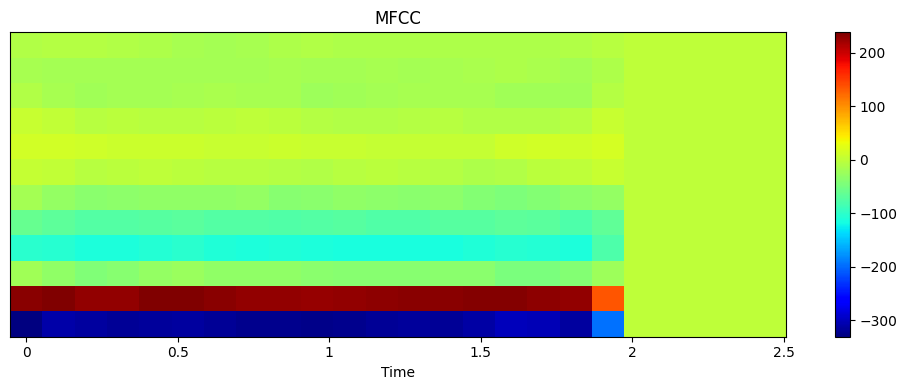

In [9]:
for i in leak_wavs[:5]:
    mfcc = wav2mfcc(i, sr=4800, desired_time=2.0, hop_length=hop_length, n_mfcc=12)
    print(mfcc.shape)
    plot_mfcc(mfcc, sr=4800, hop_length=hop_length)

(80, 76)


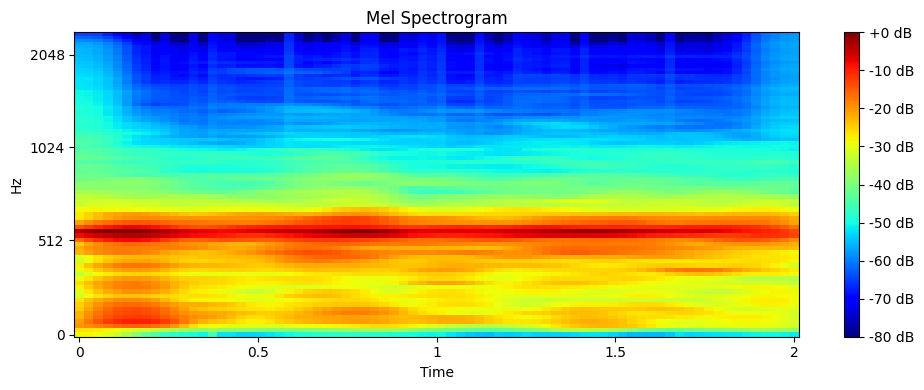

(80, 76)


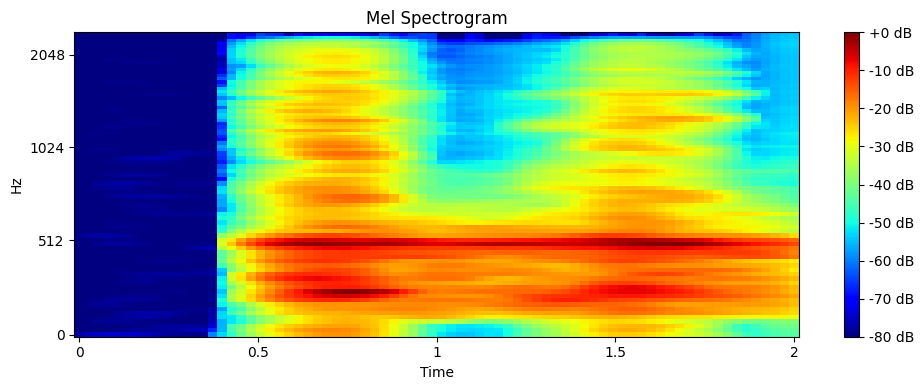

(80, 76)


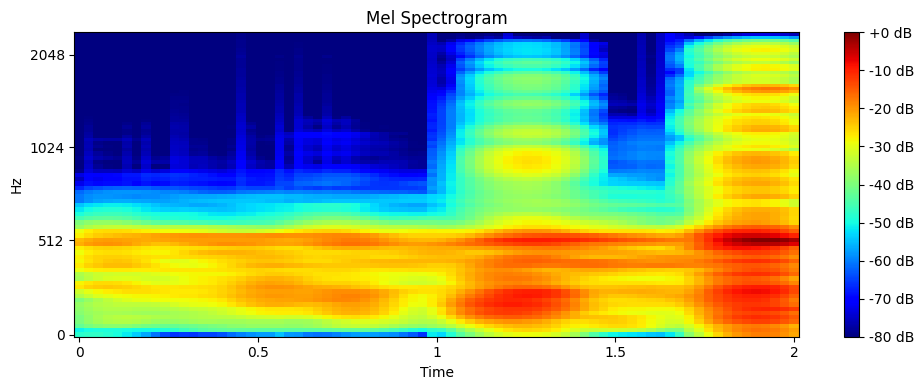

(80, 76)


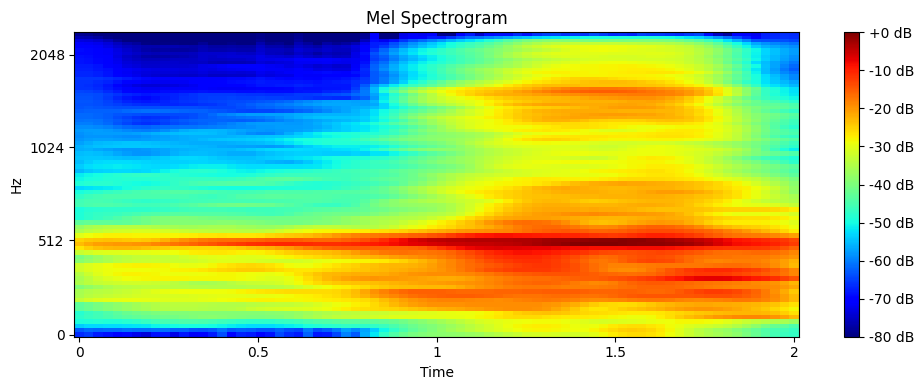

(80, 76)


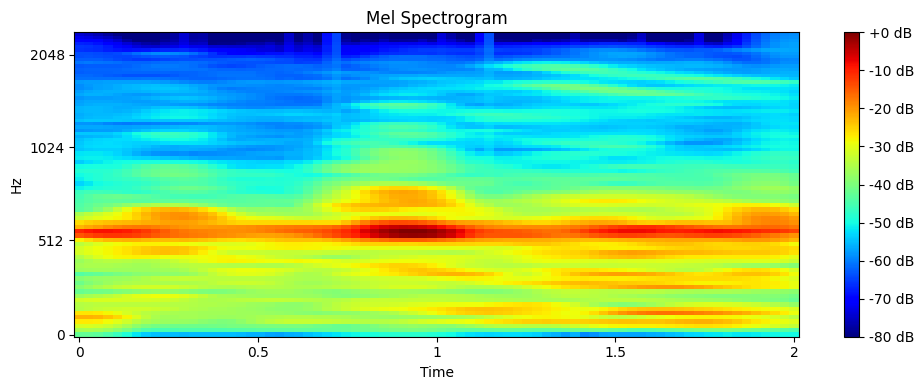

In [32]:
# 繪製 Mel 頻譜圖
hop_length = 128
for i in normal_wavs[:5]:
    mel_spectrogram = extract_features(i, sr=4800, n_mels=80, n_fft=2048, hop_length=hop_length)
    print(mel_spectrogram.shape)
    plot_mel_spectrogram(mel_spectrogram, sr=4800, hop_length=hop_length)


(152, 151)


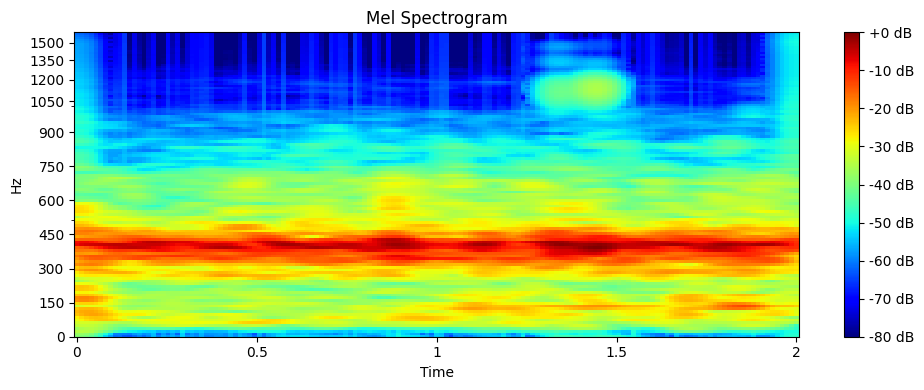

(152, 151)


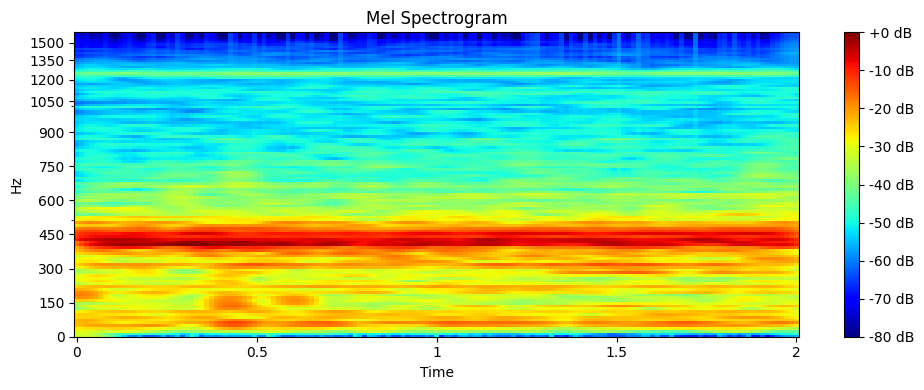

(152, 151)


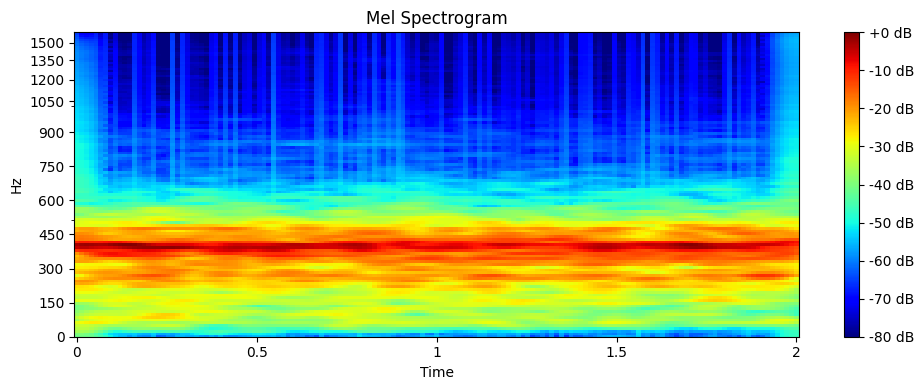

(152, 151)


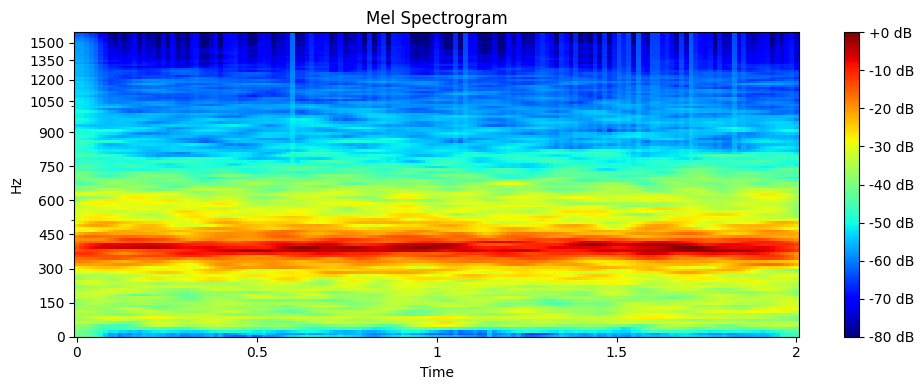

(152, 151)


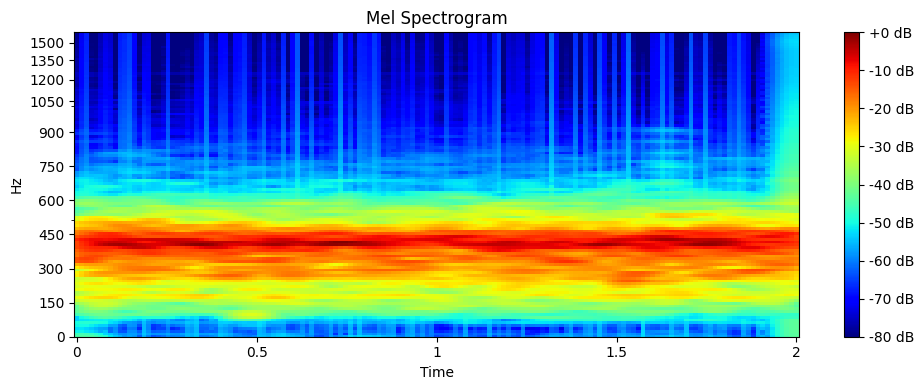

In [17]:
    
for i in leak_wavs[:5]:
    mel_spectrogram = extract_features(i, sr=4800, n_mels=120, n_fft=1024, hop_length=hop_length)
    print(mel_spectrogram.shape)
    plot_mel_spectrogram(mel_spectrogram, sr=4800, hop_length=hop_length)

In [12]:
# 繪製 STFT 頻譜圖


(192, 257)


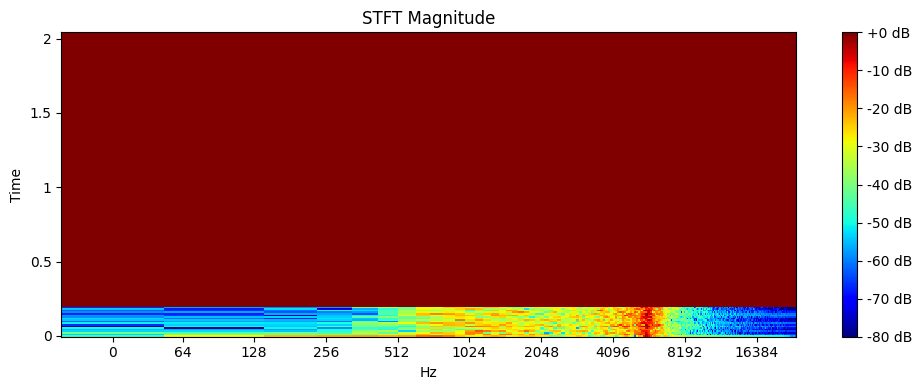

(192, 257)


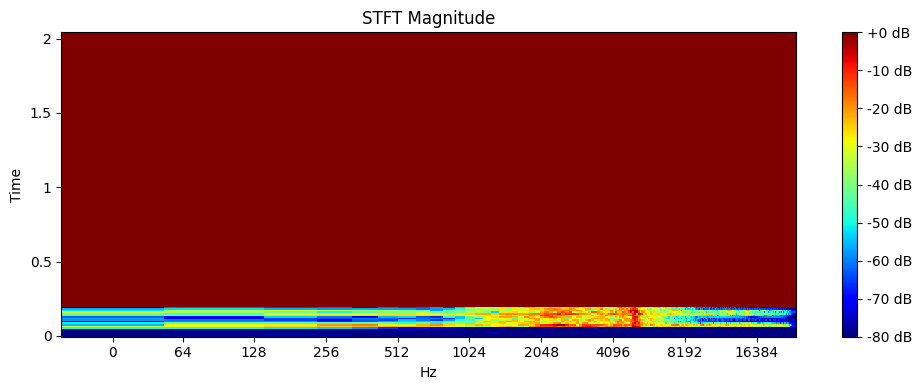

(192, 257)


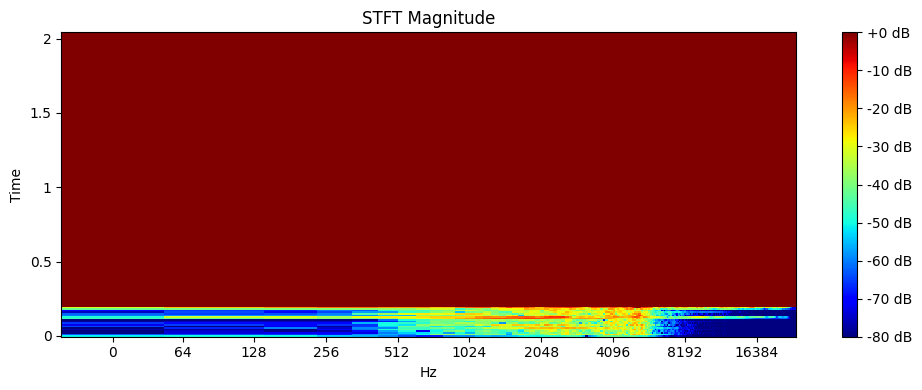

(192, 257)


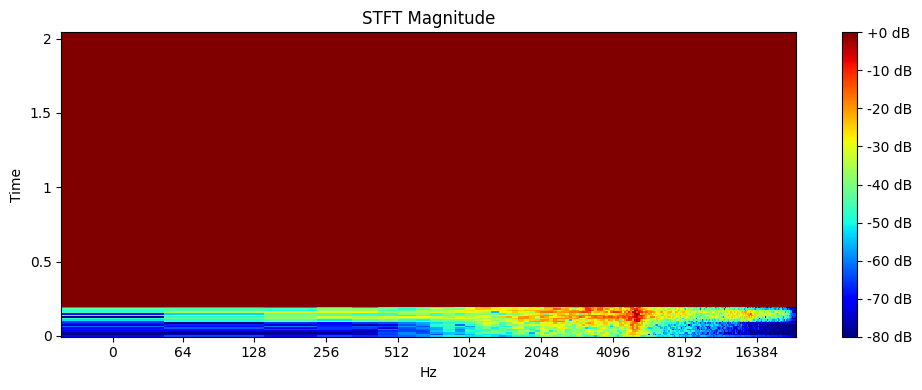

(192, 257)


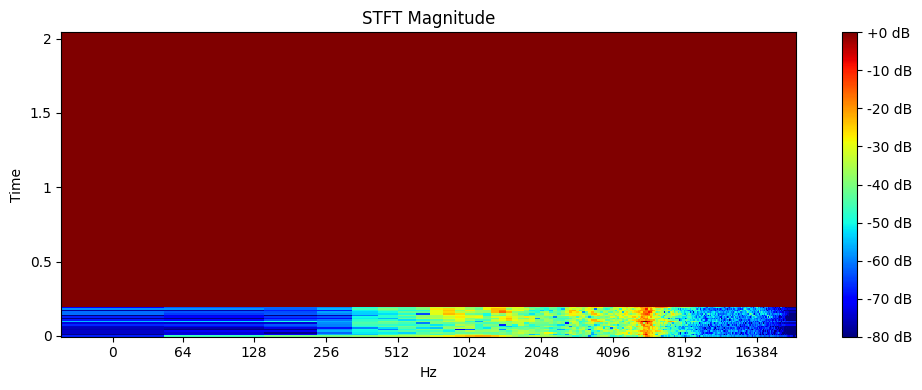

In [13]:


hop_length = 512
for i in normal_wavs[:5]:
    S_db = extract_stft_features(i, sr=48000, n_fft=512, hop_length=512)
    print(S_db.shape)
    plot_stft(S_db, sr=48000, hop_length=hop_length)

(376, 129)


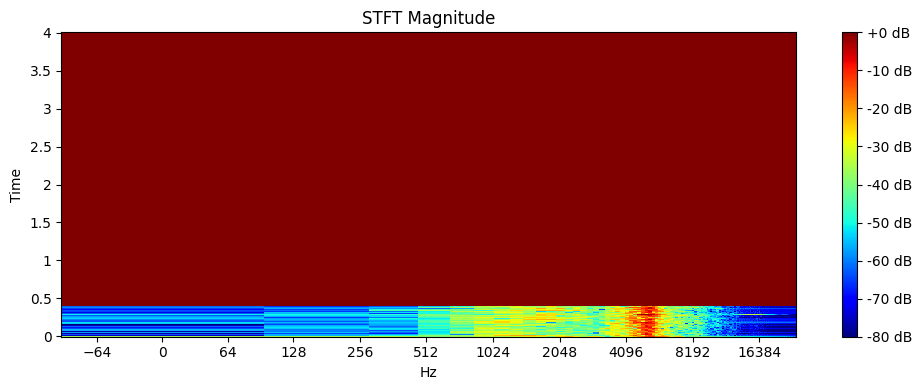

(376, 129)


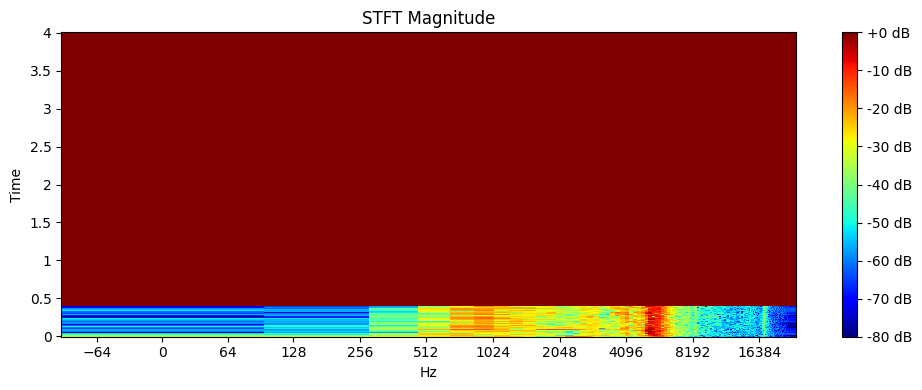

(376, 129)


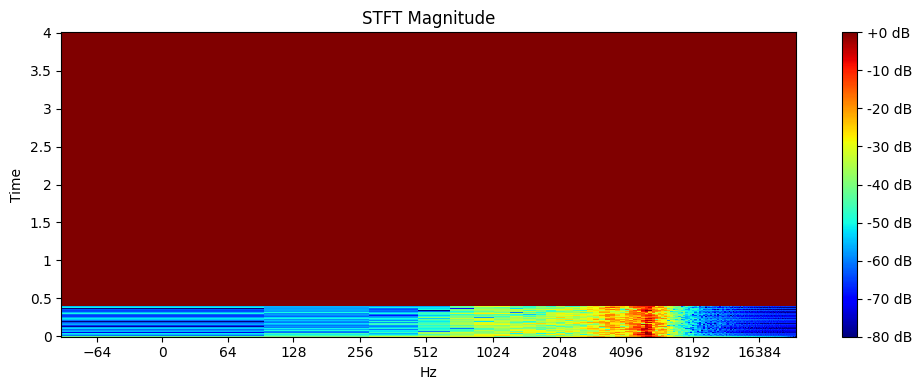

(376, 129)


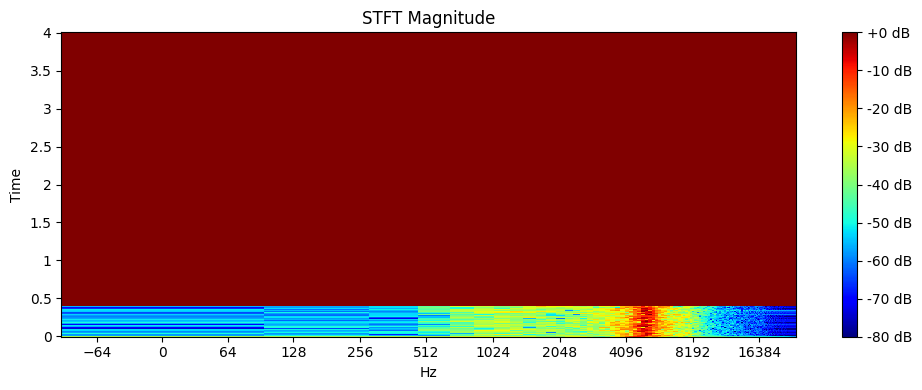

(376, 129)


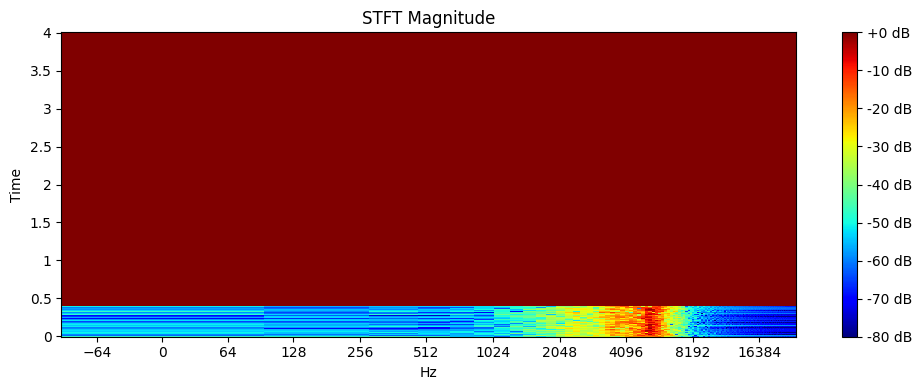

In [14]:
for i in leak_wavs[:5]:
    S_db = extract_stft_features(i, sr=48000, n_fft=256, hop_length=256)
    print(S_db.shape)
    plot_stft(S_db, sr=48000, hop_length=512)